In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import seaborn as sns
import itertools
#import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical, set_random_seed

In [2]:
# Training Images
train_paths = glob.glob("training/**/*.jpg", recursive=True) # list of paths for all images in training folder
train_images = [cv2.imread(path, 0) for path in train_paths] # list of training images
train_labels = [path.split("\\")[1] for path in train_paths] # list of training image labels
# converting to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images: ", train_images.shape)
print("Shape of train_labels: ", train_labels.shape)
print("Number of Unique Labels: ", len(np.unique(train_labels)))

Shape of train_images:  (100, 150, 150)
Shape of train_labels:  (100,)
Number of Unique Labels:  4


In [3]:
# Validation Images
test_paths = glob.glob("validation/**/*.jpg", recursive=True) # list of paths for all images in validation folder
test_images = [cv2.imread(path, 0) for path in test_paths] # list of validation images
test_labels = [path.split("\\")[1] for path in test_paths] # list of validation image labels
# converting to numpy array
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of test_images: ", test_images.shape)
print("Shape of test_labels: ", test_labels.shape)
print("Number of Unique Labels: ", len(np.unique(test_labels)))

Shape of test_images:  (40, 150, 150)
Shape of test_labels:  (40,)
Number of Unique Labels:  4


In [4]:
# Label Encoding Labels ['CR', 'CRP', 'CRT', 'CRTP'] -> [0 , 1, 2, 3]
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

In [5]:
x_train, y_train, x_test, y_test = train_images, train_labels_enc, test_images, test_labels_enc

In [6]:
def feature_extractor(image_list: np.ndarray, distances: list, angles: list):
    """ Extract Gray-Level Co-occerance Matrix (GLCM) Features 
        Parameters
        ----------
        image_list -> numpy array of images
        distances  -> list of distances (graycomatrix parameter) 
        angles     -> list of angles    (graycomatrix parameter)

        Returns
        ----------
        Pandas Dataframe of Image features of size I  * (D * A) where,
        I -> Number of images
        D -> Number of distances
        A -> Number of Angles
    """
    img_features_df = pd.DataFrame() # empty dataframe to append feature values
    
    # iterate through each image
    for img in image_list:
        df = pd.DataFrame() # empty dataframe store feature values for 'img' 
        params = list(itertools.product(distances, angles)) # possible pairs of distances and angles
        # glcm_features = ["energy", "correlation", "dissimilarity", "homogeinity", "contrast", "ASM"]

        # iterate for each distance and angle pair, calculate glcm and extract features
        for (d, ang) in params:
            GLCM = graycomatrix(img, [d], [np.deg2rad(ang)])
            df["Correlation_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "correlation")[0]
            df["Dissimilarity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "dissimilarity")[0]
            df["Homogeneity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "homogeneity")[0]
            df["Contrast_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "contrast")[0]
            df["ASM_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "ASM")[0]
            df["Energy_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "energy")[0]
        
        img_features_df =  pd.concat([img_features_df, df], ignore_index=True) # append extracted features

    return img_features_df

In [7]:
# Define GLCM Features parameters distances and angles
dists = [1, 2, 3, 4] # distances
angs  = [0, 45, 90, 135] # angles

In [8]:
x_features = feature_extractor(x_train, dists, angs) # generate glcm features for training data
scaler = StandardScaler()
x_features[x_features.columns] = scaler.fit_transform(x_features[x_features.columns]) # Scaling Features

In [9]:
print("Shape of GLCM Features for Training: ", x_features.shape)
x_features

Shape of GLCM Features for Training:  (100, 96)


,Correlation_1_0,Dissimilarity_1_0,Homogeneity_1_0,Contrast_1_0,ASM_1_0,Energy_1_0,Correlation_1_45,Dissimilarity_1_45,Homogeneity_1_45,Contrast_1_45,...,Homogeneity_4_90,Contrast_4_90,ASM_4_90,Energy_4_90,Correlation_4_135,Dissimilarity_4_135,Homogeneity_4_135,Contrast_4_135,ASM_4_135,Energy_4_135
0,-1.126581,-1.335068,1.144631,-1.280457,1.818058,1.775963,-1.088562,-1.426842,1.133758,-1.375570,...,1.592706,-1.544461,2.266309,2.188434,-0.892900,-1.724300,1.854367,-1.533657,2.287111,2.210126
1,-0.665040,-1.968588,2.166509,-1.655787,3.410594,2.989806,-0.763916,-2.004108,2.251462,-1.724587,...,2.635142,-1.704566,3.625229,3.217478,-1.459676,-2.050449,2.747300,-1.727354,3.677146,3.261661
2,-1.010395,-0.389622,-0.146223,-0.598154,0.136004,0.230035,-1.075026,-0.444658,-0.156545,-0.651911,...,0.498183,-0.945337,0.439694,0.548052,-1.004450,-0.860150,0.497431,-0.926507,0.460440,0.570207
3,-1.735040,-1.400695,1.125321,-1.303081,2.298448,2.161880,-1.721253,-1.482198,1.289317,-1.403063,...,1.683606,-1.589969,2.852279,2.647528,-1.295723,-1.862470,2.005596,-1.614859,2.910238,2.697588
4,-0.113717,-0.931235,0.577405,-0.992412,0.420214,0.518278,0.014328,-1.035883,0.555196,-1.098591,...,0.179031,-0.976678,0.369188,0.476161,-1.614874,-0.628506,-0.242490,-0.813030,0.392587,0.501094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.168589,0.189275,-0.209046,0.154925,-0.427896,-0.387953,0.002393,0.039173,-0.134869,0.002303,...,0.121013,-0.271293,-0.302174,-0.254802,0.470548,-0.175602,-0.036577,-0.245262,-0.315211,-0.270967
96,0.431054,-0.337762,0.195426,-0.374969,-0.249796,-0.185286,0.484463,-0.353186,0.213178,-0.405994,...,0.051755,-0.388803,-0.342744,-0.302080,0.719829,-0.298713,0.259661,-0.390755,-0.335895,-0.295153
97,0.572204,-0.600051,0.376744,-0.671362,-0.117338,-0.039257,0.629580,-0.637498,0.078045,-0.711390,...,0.280653,-0.489964,-0.187663,-0.123476,0.276475,-0.318703,-0.115368,-0.470591,-0.229953,-0.172369
98,1.032656,-1.048495,0.754711,-1.087717,0.173322,0.268676,1.068353,-1.054713,0.878742,-1.097206,...,0.231344,-0.762290,-0.094255,-0.018555,0.481664,-0.506319,0.037775,-0.674147,-0.145283,-0.076128


In [10]:
# Predict on Test data
# Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test, dists, angs)
test_features[test_features.columns] = scaler.transform(test_features[test_features.columns]) # Scaling Features

In [11]:
print("Shape of GLCM Features for Validation: ", test_features.shape)

Shape of GLCM Features for Validation:  (40, 96)


In [12]:
# ANN CONSTRUCTION
set_random_seed(14)
in_dim = x_features.shape[1]
ann = Sequential()
ann.add(Dense(units=25, input_dim= in_dim, activation='relu'))
ann.add(Dense(units=15, activation='relu'))
ann.add(Dense(units=8, activation='relu'))
ann.add(Dense(units=4, activation='softmax'))
ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit training data
ann.fit(x_features, to_categorical(train_labels_enc), epochs=150, batch_size=5)
# Evalute model on test data
scores = ann.evaluate(test_features, to_categorical(test_labels_enc))
print(f"\nloss: {round(scores[0], 3)} \t accuracy: {round(scores[1], 3)}") # Print loss and accuracy



Epoch 1/150


20/20 [==============================] - 2s 4ms/step - loss: 1.3273 - accuracy: 0.3500
Epoch 2/150
20/20 [==============================] - 0s 4ms/step - loss: 1.1929 - accuracy: 0.4300
Epoch 3/150
20/20 [==============================] - 0s 4ms/step - loss: 1.1098 - accuracy: 0.5000
Epoch 4/150
20/20 [==============================] - 0s 4ms/step - loss: 1.0380 - accuracy: 0.6000
Epoch 5/150
20/20 [==============================] - 0s 3ms/step - loss: 1.0018 - accuracy: 0.5600
Epoch 6/150
20/20 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6100
Epoch 7/150
20/20 [==============================] - 0s 4ms/step - loss: 0.9023 - accuracy: 0.6000
Epoch 8/150
20/20 [==============================] - 0s 4ms/step - loss: 0.8657 - accuracy: 0.5900
Epoch 9/150
20/20 [==============================] - 0s 4ms/step - loss: 0.8245 - accuracy: 0.6000
Epoch 10/150
20/20 [==============================] - 0s 5ms/step - loss: 0.8113 - accuracy: 0.6300
Epoch

In [13]:
# Predict on test data
test_prediction = ann.predict(test_features)

2/2 [==============================] - 0s 6ms/step


In [14]:
test_prediction=np.argmax(test_prediction, axis=1) # get the class with the highest probability value
test_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [15]:
# Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)
test_prediction # predicted labels for test images

array(['CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRTP',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP'], dtype='<U4')

In [16]:
test_labels # True labels of test images

array(['CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP'], dtype='<U4')

In [17]:
# Accuracy
print ("Accuracy:", metrics.accuracy_score(test_labels, test_prediction))

Accuracy: 0.95


In [18]:
# Precision 
print("Precision:\n[CR, CRP, CRT, CRTP]\t", metrics.precision_score(test_labels, test_prediction, average=None))


Precision:
[CR, CRP, CRT, CRTP]	 [1.         0.9        1.         0.90909091]


In [19]:
# Recall
print("Recall:\n[CR, CRP, CRT, CRTP]\t", metrics.recall_score(test_labels, test_prediction, average=None))

Recall:
[CR, CRP, CRT, CRTP]	 [0.9 0.9 1.  1. ]


In [20]:
# F1 Score
print("F1 Scores:\n[CR, CRP, CRT, CRTP]\t", metrics.f1_score(test_labels, test_prediction, average=None))

F1 Scores:
[CR, CRP, CRT, CRTP]	 [0.94736842 0.9        1.         0.95238095]


In [21]:
def gen_annotations(cf_matrix):
    """
    Generates Annotation for each cell in confusion matrix
    args:
        cf_matrix: confusion matrix (numpy array)
    """
    sums = np.sum(cf_matrix, axis=1, keepdims=True) # sum of each row
    cf_perc = 100*cf_matrix/sums # converting to percentage
    annot = np.empty_like(cf_matrix).astype(str) # creating a empty numpy array to store annotations for each cell
    # iterate through each cell and store the annotation
    rows, cols = cf_matrix.shape 
    for i in range(rows):
        for j in range(cols):
            val = cf_matrix[i, j]
            perc_val = cf_perc[i, j]
            if val == 0: 
                annot[i, j] = '0'
            else:
                sum_val = sums[i][0]
                annot[i, j] = "%.1f%%\n(%d/%d)" % (perc_val, val, sum_val)
    return annot   

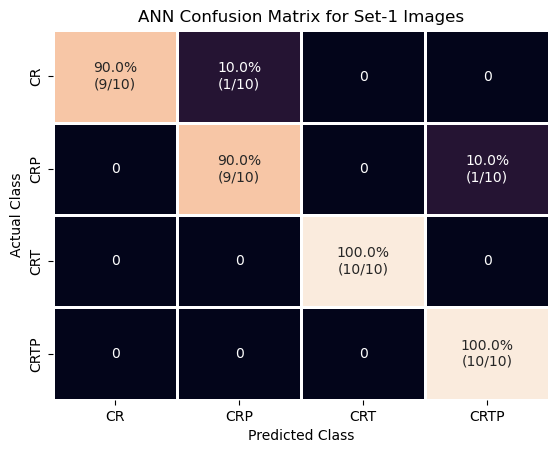

In [23]:
# Plot confusion matrix
cm = metrics.confusion_matrix(test_labels, test_prediction)
annot = gen_annotations(cm)
fig = sns.heatmap(cm, annot=annot, fmt='', cbar=False, linewidth=1,
            xticklabels=['CR', 'CRP', 'CRT', 'CRTP'],
            yticklabels=['CR', 'CRP', 'CRT', 'CRTP']).get_figure()

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('ANN Confusion Matrix for Set-1 Images')
plt.show()
fig.savefig("plots/ann/cfmatrix_ann_set_1.png", dpi=600)

## Shap Analysis

In [22]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [23]:
# get shap values
shap_values = shap.KernelExplainer(ann.predict, x_features).shap_values(test_features)

4/4 [==============================] - 0s 5ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

7000/7000 [==============================] - 19s 3ms/step


  2%|▎         | 1/40 [00:28<18:47, 28.91s/it]

7000/7000 [==============================] - 18s 3ms/step


  5%|▌         | 2/40 [00:56<17:41, 27.93s/it]

7000/7000 [==============================] - 18s 3ms/step


  8%|▊         | 3/40 [01:23<17:02, 27.64s/it]

7000/7000 [==============================] - 18s 3ms/step


 10%|█         | 4/40 [01:50<16:27, 27.44s/it]

7000/7000 [==============================] - 19s 3ms/step


 12%|█▎        | 5/40 [02:17<15:59, 27.41s/it]

7000/7000 [==============================] - 19s 3ms/step


 15%|█▌        | 6/40 [02:45<15:37, 27.56s/it]

7000/7000 [==============================] - 19s 3ms/step


 18%|█▊        | 7/40 [03:13<15:08, 27.52s/it]

7000/7000 [==============================] - 18s 3ms/step


 20%|██        | 8/40 [03:41<14:44, 27.65s/it]

7000/7000 [==============================] - 19s 3ms/step


 22%|██▎       | 9/40 [04:08<14:15, 27.61s/it]

7000/7000 [==============================] - 19s 3ms/step


 25%|██▌       | 10/40 [04:36<13:47, 27.59s/it]

7000/7000 [==============================] - 18s 3ms/step


 28%|██▊       | 11/40 [05:03<13:18, 27.53s/it]

7000/7000 [==============================] - 18s 3ms/step


 30%|███       | 12/40 [05:31<12:49, 27.49s/it]

7000/7000 [==============================] - 18s 3ms/step


 32%|███▎      | 13/40 [05:58<12:20, 27.43s/it]

7000/7000 [==============================] - 18s 3ms/step


 35%|███▌      | 14/40 [06:25<11:52, 27.40s/it]

7000/7000 [==============================] - 18s 3ms/step


 38%|███▊      | 15/40 [06:52<11:24, 27.39s/it]

7000/7000 [==============================] - 19s 3ms/step


 40%|████      | 16/40 [07:20<10:58, 27.43s/it]

7000/7000 [==============================] - 19s 3ms/step


 42%|████▎     | 17/40 [07:48<10:32, 27.49s/it]

7000/7000 [==============================] - 19s 3ms/step


 45%|████▌     | 18/40 [08:15<10:04, 27.46s/it]

7000/7000 [==============================] - 18s 3ms/step


 48%|████▊     | 19/40 [08:42<09:35, 27.39s/it]

7000/7000 [==============================] - 18s 3ms/step


 50%|█████     | 20/40 [09:10<09:08, 27.43s/it]

7000/7000 [==============================] - 19s 3ms/step


 52%|█████▎    | 21/40 [09:37<08:42, 27.48s/it]

7000/7000 [==============================] - 18s 3ms/step


 55%|█████▌    | 22/40 [10:04<08:11, 27.29s/it]

7000/7000 [==============================] - 18s 3ms/step


 57%|█████▊    | 23/40 [10:32<07:44, 27.30s/it]

7000/7000 [==============================] - 18s 3ms/step


 60%|██████    | 24/40 [10:58<07:14, 27.17s/it]

7000/7000 [==============================] - 18s 3ms/step


 62%|██████▎   | 25/40 [11:25<06:46, 27.10s/it]

7000/7000 [==============================] - 19s 3ms/step


 65%|██████▌   | 26/40 [11:53<06:20, 27.16s/it]

7000/7000 [==============================] - 19s 3ms/step


 68%|██████▊   | 27/40 [12:20<05:53, 27.18s/it]

7000/7000 [==============================] - 18s 3ms/step


 70%|███████   | 28/40 [12:47<05:25, 27.16s/it]

7000/7000 [==============================] - 18s 3ms/step


 72%|███████▎  | 29/40 [13:14<04:58, 27.15s/it]

7000/7000 [==============================] - 19s 3ms/step


 75%|███████▌  | 30/40 [13:42<04:33, 27.36s/it]

7000/7000 [==============================] - 18s 3ms/step


 78%|███████▊  | 31/40 [14:09<04:05, 27.32s/it]

7000/7000 [==============================] - 20s 3ms/step


 80%|████████  | 32/40 [14:39<03:43, 27.91s/it]

7000/7000 [==============================] - 20s 3ms/step


 82%|████████▎ | 33/40 [15:08<03:19, 28.49s/it]

7000/7000 [==============================] - 20s 3ms/step


 85%|████████▌ | 34/40 [15:38<02:53, 28.83s/it]

7000/7000 [==============================] - 19s 3ms/step


 88%|████████▊ | 35/40 [16:06<02:23, 28.71s/it]

7000/7000 [==============================] - 20s 3ms/step


 90%|█████████ | 36/40 [16:35<01:54, 28.73s/it]

7000/7000 [==============================] - 20s 3ms/step


 92%|█████████▎| 37/40 [17:05<01:27, 29.07s/it]

7000/7000 [==============================] - 20s 3ms/step


 95%|█████████▌| 38/40 [17:34<00:57, 28.96s/it]

7000/7000 [==============================] - 19s 3ms/step


 98%|█████████▊| 39/40 [18:02<00:28, 28.72s/it]

7000/7000 [==============================] - 19s 3ms/step


100%|██████████| 40/40 [18:30<00:00, 27.76s/it]


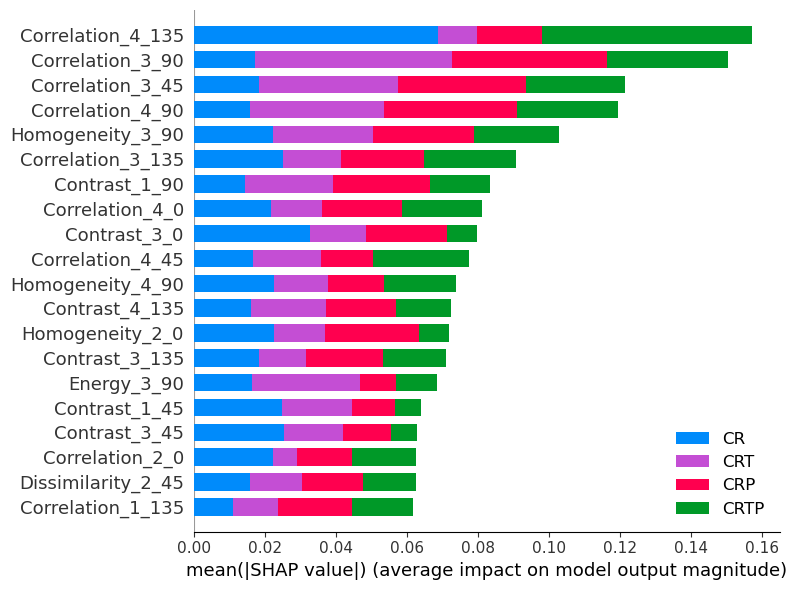

In [24]:
# plot summary
shap.summary_plot(shap_values, test_features, class_names=["CR", "CRP", "CRT", "CRTP"], plot_size=[8,6], show=False)
plt.savefig("plots/ann/shap_summary_all.png", dpi=600)

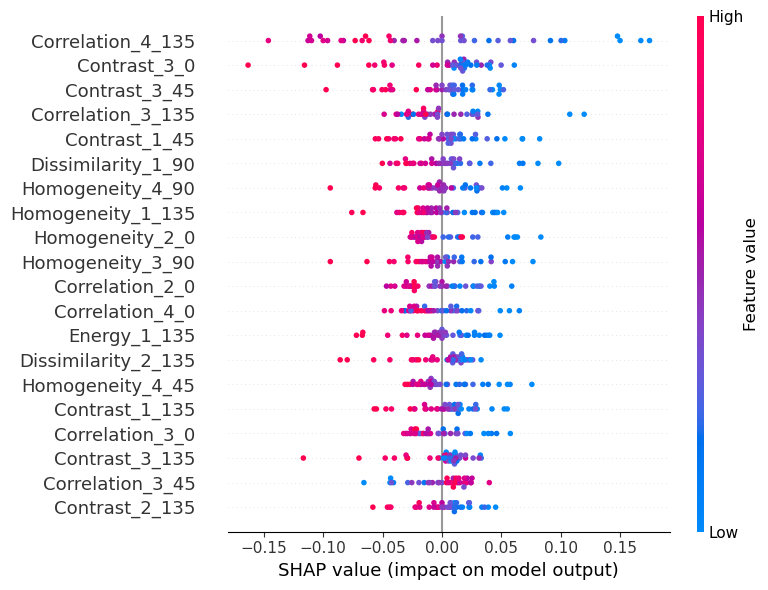

In [25]:
shap.summary_plot(shap_values[0], test_features, plot_size=[8,6], show=False) # summary plot for 'CR' class
plt.savefig("plots/ann/shap_summary_CR.png", dpi=600)

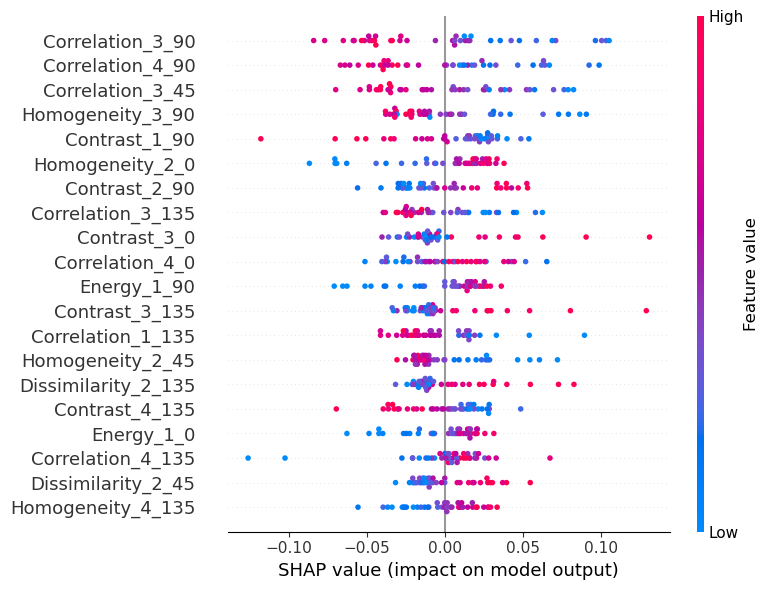

In [26]:
shap.summary_plot(shap_values[1], test_features, plot_size=[8,6], show=False) # summary plot for 'CRP' class
plt.savefig("plots/ann/shap_summary_CRP.png", dpi=600)

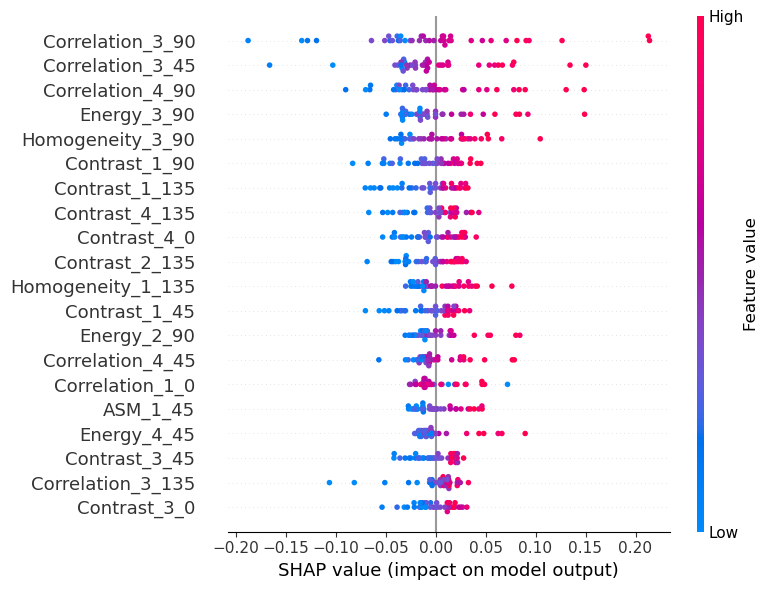

In [27]:
shap.summary_plot(shap_values[2], test_features, plot_size=[8,6], show=False) # summary plot for 'CRT' class
plt.savefig("plots/ann/shap_summary_CRT.png", dpi=600)

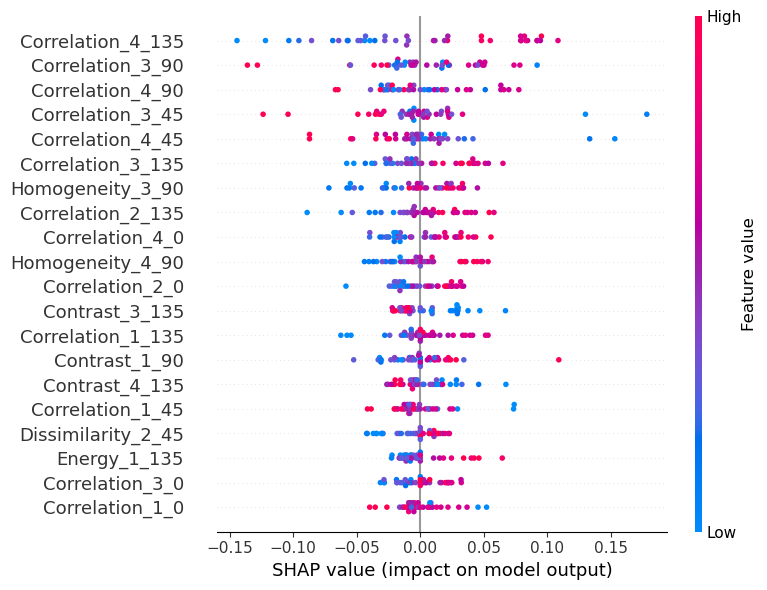

In [28]:
shap.summary_plot(shap_values[3], test_features, plot_size=[8,6], show=False) # summary plot for 'CRTP' class
plt.savefig("plots/ann/shap_summary_CRTP.png", dpi=600)

## Cross Validation

In [29]:
# Accumulate all the training and test image features and labels
all_features = pd.concat([x_features, test_features], ignore_index=True)
all_labels_enc = np.append(train_labels_enc, test_labels_enc)

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_per_fold = []

# iterate through each fold
for train_idx, test_idx in kf.split(all_features):
    X_train, X_test = all_features.iloc[train_idx], all_features.iloc[test_idx]
    y_train, y_test = all_labels_enc[train_idx], all_labels_enc[test_idx]
    # Fit training data
    ann.fit(X_train, to_categorical(y_train), epochs=150, batch_size=5, verbose=0)
    # Evalute model on test data
    scores = ann.evaluate(X_test, to_categorical(y_test), verbose=0)
    # predict using ann
    y_pred = ann.predict(X_test)
    # get the class with the highest probability
    y_pred_labels = np.argmax(y_pred, axis=1)
    # Calculate accuracy
    acc = metrics.accuracy_score(y_test, y_pred_labels)
    acc_per_fold.append(acc)

1/1 [==============================] - 0s 50ms/step


In [31]:
# Average Accuracy Score
avg_accuracy =  np.mean(acc_per_fold)
print(f'Average Accuracy: {avg_accuracy:.4f}')

Average Accuracy: 0.9714
